In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import random
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image
import pygame 

slim = tf.contrib.slim

HEIGHT, WIDTH, CHANNEL = 128, 128, 3
BATCH_SIZE = 64
EPOCH = 5000
version = 'hondaEnhanced'
newPoke_path = './drive/My Drive/HONDA/' + version

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
def lrelu(x, n, leak=0.2): 
    return tf.maximum(x, leak * x, name=n) 

In [3]:
def process_data():   
    current_dir = os.getcwd()
    # parent = os.path.dirname(current_dir)
    pokemon_dir = os.path.join(current_dir, 'dataindex')
    images = []
    for each in os.listdir(pokemon_dir):
        images.append(os.path.join(pokemon_dir,each))
    # print images    
    all_images = tf.convert_to_tensor(images, dtype = tf.string)
    
    images_queue = tf.train.slice_input_producer(
                                        [all_images])
                                        
    content = tf.read_file(images_queue[0])
    image = tf.image.decode_jpeg(content, channels = CHANNEL)
    # sess1 = tf.Session()
    # print sess1.run(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.1)
    image = tf.image.random_contrast(image, lower = 0.9, upper = 1.1)
    # noise = tf.Variable(tf.truncated_normal(shape = [HEIGHT,WIDTH,CHANNEL], dtype = tf.float32, stddev = 1e-3, name = 'noise')) 
    # print image.get_shape()
    size = [HEIGHT, WIDTH]
    image = tf.image.resize_images(image, size)
    image.set_shape([HEIGHT,WIDTH,CHANNEL])
    # image = image + noise
    # image = tf.transpose(image, perm=[2, 0, 1])
    # print image.get_shape()
    
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    
    iamges_batch = tf.train.shuffle_batch(
                                    [image], batch_size = BATCH_SIZE,
                                    num_threads = 4, capacity = 200 + 3* BATCH_SIZE,
                                    min_after_dequeue = 200)
    num_images = len(images)

    return iamges_batch, num_images

In [4]:
def generator(input, random_dim, is_train, reuse=False):
    c4, c8, c16, c32, c64 = 512, 256, 128, 64, 32 # channel num
    s4 = 4
    output_dim = CHANNEL  # RGB image
    with tf.variable_scope('gen',reuse=tf.AUTO_REUSE) as scope:
        if reuse:
            scope.reuse_variables()
        w1 = tf.get_variable('w1', shape=[random_dim, s4 * s4 * c4], dtype=tf.float32,
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b1 = tf.get_variable('b1', shape=[c4 * s4 * s4], dtype=tf.float32,
                             initializer=tf.constant_initializer(0.0))
        flat_conv1 = tf.add(tf.matmul(input, w1), b1, name='flat_conv1')
         #Convolution, bias, activation, repeat! 
        conv1 = tf.reshape(flat_conv1, shape=[-1, s4, s4, c4], name='conv1')
        bn1 = tf.contrib.layers.batch_norm(conv1, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn1')
        act1 = tf.nn.relu(bn1, name='act1')
        # 8*8*256
        #Convolution, bias, activation, repeat! 
        conv2 = tf.layers.conv2d_transpose(act1, c8, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv2')
        bn2 = tf.contrib.layers.batch_norm(conv2, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn2')
        act2 = tf.nn.relu(bn2, name='act2')
        # 16*16*128
        conv3 = tf.layers.conv2d_transpose(act2, c16, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv3')
        bn3 = tf.contrib.layers.batch_norm(conv3, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn3')
        act3 = tf.nn.relu(bn3, name='act3')
        # 32*32*64
        conv4 = tf.layers.conv2d_transpose(act3, c32, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv4')
        bn4 = tf.contrib.layers.batch_norm(conv4, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn4')
        act4 = tf.nn.relu(bn4, name='act4')
        # 64*64*32
        conv5 = tf.layers.conv2d_transpose(act4, c64, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv5')
        bn5 = tf.contrib.layers.batch_norm(conv5, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn5')
        act5 = tf.nn.relu(bn5, name='act5')
        
        #128*128*3
        conv6 = tf.layers.conv2d_transpose(act5, output_dim, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv6')
        # bn6 = tf.contrib.layers.batch_norm(conv6, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn6')
        act6 = tf.nn.tanh(conv6, name='act6')
        return act6

In [5]:
def save_images(images, size, image_path,epoch):
  return imsave(inverse_transform(images), size, image_path,epoch)

def imsave(images, size, path,epoch):
  image = np.squeeze(merge(images, size))*255
  image = crop_left(image,128,128)
  #print(image)
  cv2.imwrite(path, image) 
  #Image.open('nod.jpg')
  #img.show()
  #return image.save(path)
  #return scipy.misc.imsave(path, image)
def crop_left(img,cropx,cropy):
    #print(img.shape)
    #startx=0
    #starty=0
    #y,x,c = img.shape
    #startx = x//2-(cropx//2)
    #starty = y//2-(cropy//2)    
    return img[0:cropy,0:cropx,:]
def buff_image(images,size):
    images = inverse_transform(images)
    return np.squeeze(merge(images, size))*255
    
def inverse_transform(images):
  return (images+1.)/2.

def merge(images, size):
  h, w = images.shape[1], images.shape[2]
  if (images.shape[3] in (3,4)):
    c = images.shape[3]
    img = np.zeros((h * size[0], w * size[1], c))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h:j * h + h, i * w:i * w + w, :] = image
    return img
  elif images.shape[3]==1:
    img = np.zeros((h * size[0], w * size[1]))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
    return img
  else:
    raise ValueError('in merge(images,size) images parameter '
                     'must have dimensions: HxW or HxWx3 or HxWx4')

def put_arr(surface, myarr):
    bv = surface.get_buffer()
    bv.write(myarr.tostring(), 0)
def simpan_tok(sess,fake_image):
    while True:
        sample_noise = np.random.uniform(-1, 1, size=[64, 100]).astype(np.float32)
        imgtest = sess.run(fake_image, feed_dict={random_input: sample_noise, is_train: False})
        save_images(imgtest, [8,8] ,'step.jpg' ,0)
        
        sample_noise = sample_noise*0
        imgtest = sess.run(fake_image, feed_dict={random_input: sample_noise, is_train: False})
        save_images(imgtest, [8,8] ,'step2.jpg' ,0)
def pygameImg(sess,fake_image):
    pygame.init() 
    white = (255, 255, 255)
    X = 128
    Y = 128
    display_surface = pygame.display.set_mode((X, Y )) 
    pygame.display.set_caption('Image') 
    image = pygame.image.load(r'C:\Users\us3rname\python project\Honda\foo0.jpg') 
    while True : 
        display_surface.fill(white) 
        sample_noise = np.random.uniform(-1, 1, size=[64, 100]).astype(np.float32)
        imgtest = sess.run(fake_image, feed_dict={random_input: sample_noise, is_train: False})
        save_images(imgtest, [8,8] ,'step.jpg' ,0)
        image = pygame.image.load(r'C:\Users\us3rname\python project\Honda\step.jpg') 
        display_surface.blit(image, (0, 0)) 
        draw_sliders()
        #display_surface.blit(put_arr(display_surface,imgtest), (0, 0)) 
        for event in pygame.event.get() : 
            if event.type == pygame.QUIT : 
                pygame.quit() 
                #quit() 
            else :
                pygame.display.update()

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct

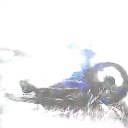

In [6]:
#batch 64 randomdim 100
random_dim=100
batch_size = 1
with tf.variable_scope('input'):
        #real and fake image placholders
        real_image = tf.placeholder(tf.float32, shape = [None, HEIGHT, WIDTH, CHANNEL], name='real_image')
        random_input = tf.placeholder(tf.float32, shape=[None, random_dim], name='rand_input')
        is_train = tf.placeholder(tf.bool, name='is_train')  
fake_image = generator(random_input, random_dim, is_train)
    

image_batch, samples_num = process_data()
  
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

modelpath='model/hondaEnhanced/1300'
ckpt = tf.train.latest_checkpoint('model/hondaEnhanced')
saver.restore(sess, modelpath)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
train_image = sess.run(image_batch)

sample_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, random_dim]).astype(np.float32)
##sample_noise = np.random.uniform(-2, -2, size=[batch_size, random_dim]).astype(np.float32)
imgtest = sess.run(fake_image, feed_dict={random_input: sample_noise, is_train: False})
#pygameImg(sess,fake_image)
save_images(imgtest, [8,8] ,version+'.jpg' ,0)
Image.open(version+'.jpg')

In [8]:
simpan_tok(sess,fake_image)

KeyboardInterrupt: 

In [ ]:
sample_noise = np.random.uniform(-1.0, 0, size=[1, random_dim]).astype(np.float32)
##sample_noise = np.random.uniform(-2, -2, size=[batch_size, random_dim]).astype(np.float32)
imgtest = sess.run(fake_image, feed_dict={random_input: custom, is_train: False})
#pygameImg(sess,fake_image)
save_images(imgtest, [8,8] ,'batch size 01.jpg' ,0)

In [ ]:
print(samples_num)

In [ ]:
avb=np.random.uniform(-1, 1, size=[2, 3]).astype(np.float32)
bvb=avb*-1
print(avb)
print(bvb)

In [ ]:

from scipy import linalg as LA

A = np.random.randint(0, 10, 25).reshape(5, 5)


e_vals, e_vecs = LA.eig(A)

In [ ]:
#print(tf.placeholder(tf.float32, shape=[None, random_dim], name='rand_input'))
fake = generator(random_input, random_dim, is_train)
print(fake)

In [ ]:
np.random.uniform(-1, -1, size=[1, 100]).astype(np.float32)

In [ ]:
custom = np.array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.]])
for x in range(0,99):
    i=-1
    print(x)
    while i<=1:
        #sample_noise = np.random.uniform(-1.0, 0, size=[1, random_dim]).astype(np.float32)
        ##sample_noise = np.random.uniform(-2, -2, size=[batch_size, random_dim]).astype(np.float32)
        custom[0][x]=i
        i=i+0.01
        imgtest = sess.run(fake_image, feed_dict={random_input: custom, is_train: False})
        #pygameImg(sess,fake_image)
        save_images(imgtest, [8,8] ,'batch size 01.jpg' ,0)

Image.open('batch size 01.jpg')

In [ ]:
from scipy import misc
imagio = misc.imread('dataindex/1.jpg')
imagio = imagio/255.0
#imagio = imagio[:,:,:].reshape((128,128,3))/255.0
print(imagio.shape)

In [7]:
import pygame, math, sys
pygame.init()

X = 900  # screen width
Y = 600  # screen height

WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 50, 50)
YELLOW = (255, 255, 0)
GREEN = (0, 255, 50)
BLUE = (50, 50, 255)
GREY = (200, 200, 200)
ORANGE = (200, 100, 50)
CYAN = (0, 255, 255)
MAGENTA = (255, 0, 255)
TRANS = (1, 1, 1)

flow = False  # controls type of color flow


class Button():
    def __init__(self, index, txt, location, bg=WHITE, fg=BLACK, size=(80, 30), font_name="Segoe Print", font_size=16):
        self.color = bg  # the static (normal) color
        self.bg = bg  # actual background color, can change on mouseover
        self.fg = fg  # text color
        self.size = size
        self.index = index
        self.font = pygame.font.SysFont(font_name, font_size)
        self.txt = txt
        self.txt_surf = self.font.render(self.txt, 1, self.fg)
        self.txt_rect = self.txt_surf.get_rect(center=[s//2 for s in self.size])

        self.surface = pygame.surface.Surface(size)
        self.rect = self.surface.get_rect(center=location)

       

    def draw(self):
        self.mouseover()

        self.surface.fill(self.bg)
        self.surface.blit(self.txt_surf, self.txt_rect)
        screen.blit(self.surface, self.rect)

    def mouseover(self):
        self.bg = self.color
        pos = pygame.mouse.get_pos()
        if self.rect.collidepoint(pos):
            self.bg = GREY  # mouseover color

        
def random_honda(slide_val):
    print('1')
    return np.random.uniform(-1, 1, size=[1, 100]).astype(np.float32)

def invert_honda(slide_val):
    print('2')
    return slide_val*-1


def mousebuttondown(slide_val):
    pos = pygame.mouse.get_pos()
    for button in buttons:
        if button.rect.collidepoint(pos):
            if button.index == 1 :
                random_honda(slide_val)
            if button.index == 2 :
                invert_honda(slide_val)
            return True
    return False
        
class Slider():
    def __init__(self, name, val, maxi, mini, posx, posy=20):
        self.val = val  # start value
        self.maxi = maxi  # maximum at slider position right
        self.mini = mini  # minimum at slider position left
        self.xpos = posx  # x-location on screen
        self.ypos = posy
        self.surf = pygame.surface.Surface((90, 25))
        self.hit = False  # the hit attribute indicates slider movement due to mouse interaction

        self.txt_surf = font.render(name, 1, BLACK)
        self.txt_rect = self.txt_surf.get_rect(center=(50, 5))

        # Static graphics - slider background #
        self.surf.fill((100, 100, 100))
        #pygame.draw.rect(self.surf, GREY, [0, 0, 100, 50], 3)
        pygame.draw.rect(self.surf, ORANGE, [5, 0, 80, 10], 0)
        pygame.draw.rect(self.surf, WHITE, [5, 15, 80, 5], 0)

        self.surf.blit(self.txt_surf, self.txt_rect)  # this surface never changes

        # dynamic graphics - button surface #
        self.button_surf = pygame.surface.Surface((20, 20))
        self.button_surf.fill(TRANS)
        self.button_surf.set_colorkey(TRANS)
        pygame.draw.circle(self.button_surf, BLACK, (5, 10), 6, 0)
        pygame.draw.circle(self.button_surf, ORANGE, (5, 10), 4, 0)

    def draw(self):
        """ Combination of static and dynamic graphics in a copy of
    the basic slide surface
    """
        # static
        surf = self.surf.copy()

        # dynamic
        pos = (10+int((self.val-self.mini)/(self.maxi-self.mini)*80), 17)
        self.button_rect = self.button_surf.get_rect(center=pos)
        surf.blit(self.button_surf, self.button_rect)
        self.button_rect.move_ip(self.xpos, self.ypos)  # move of button box to correct screen position

        # screen
        screen.blit(surf, (self.xpos, self.ypos))

    def move(self):
        """
    The dynamic part; reacts to movement of the slider button.
    """
        self.val = (pygame.mouse.get_pos()[0] - self.xpos - 10) / 80 * (self.maxi - self.mini) + self.mini
        if self.val < self.mini:
            self.val = self.mini
        if self.val > self.maxi:
            self.val = self.maxi

class Honda():     
    def draw(slide_val):
        imgtest = sess.run(fake_image, feed_dict={random_input: slide_val, is_train: False})
        #pygameImg(sess,fake_image)
        gg = crop_images(imgtest, [8,8])
        
        sur = pygame.surface.Surface((128, 128))
        gg = np.swapaxes(gg, 0, 1)
        pygame.pixelcopy.array_to_surface(sur, gg)
        screen.blit(sur, (0, 0))
    
    def crop_images(image, size):
        image = inverse_transform(image)
        image = np.squeeze(merge(image, size))*255
        image = image[0:128,0:128,:]
        return image

def update_slide_val(slide_val,slides):
    for x in range(100):
        #slide_val[0].append(slides[x].val)
        #slide_val[0] = np.append(slide_val[0],slides[x].val)
        slide_val[0][x] = slides[x].val
    return slide_val
def draw_honda(slide_val,screen):
    imgtest = sess.run(fake_image, feed_dict={random_input: slide_val, is_train: False})
    #pygameImg(sess,fake_image)
    gg = crop_images(imgtest, [8,8])
        
    
    img = pygame.image.load('slid.jpg')
    screen.blit(img, (700, 50))
    
def crop_images(image, size):
    image = inverse_transform(image)
    image = np.squeeze(merge(image, size))*255
    image = image[0:128,0:128,:]
    cv2.imwrite('slid.jpg', image)

font = pygame.font.SysFont("Verdana", 12)
screen = pygame.display.set_mode((X, Y))
clock = pygame.time.Clock()

COLORS = [MAGENTA, RED, YELLOW, GREEN, CYAN, BLUE]
#xcolor = Gradient(COLORS, X).gradient

slide_val = np.zeros((1,100))
slides = []
posx=0
posy=5
for x in range(100):
    slides.append(Slider("Noise"+str(x+1),0,1,-1,posx,posy))
    posx=posx+95
    if len(slides) % 5 == 0:
        posy = posy+30
        posx=0       
slide_val =update_slide_val(slide_val,slides)

button_01 = Button(1, "Random!", (765, 300))
button_02 = Button(2, "Invert!", (765, 350), bg=(50, 200, 20))
buttons = [button_01, button_02]

pen = Slider("Pen", 10, 15, 1, 25)
freq = Slider("Freq", 1, 3, 0.2, 150)
jmp = Slider("Jump", 10, 20, 1, 275)
size = Slider("Size", 200, 200, 20, 400)
focus = Slider("Focus", 0, 6, 0, 525)
phase = Slider("Phase", 3.14, 6, 0.3, 650)
speed = Slider("Speed", 50, 150, 10, 775)
#slides = [pen,pen,pen,jmp,jmp, freq, jmp, size, focus, phase, speed,speed,speed]

num = 0

while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()
        elif event.type == pygame.MOUSEBUTTONDOWN:
            pos = pygame.mouse.get_pos()
            slide_val =update_slide_val(slide_val,slides)
            for button in buttons:
                if button.rect.collidepoint(pos):
                    if button.index == 1 :
                        slide_val = random_honda(slide_val)
                        for x in range(100):
                            slides[x].val = slide_val[0][x]
                        print(slide_val)
                    if button.index == 2 :
                        slide_val = invert_honda(slide_val)
                        for x in range(100):
                            slides[x].val = slide_val[0][x]
                        print(slide_val)
            for s in slides:
                if s.button_rect.collidepoint(pos):
                    s.hit = True
                    update_gambar = True
                    print('njir')
        elif event.type == pygame.MOUSEBUTTONUP:
            for s in slides:
                s.hit = False

    # Move slides
    for s in slides:
        if s.hit:
            s.move()

    # Update screen
    screen.fill(BLACK)
    #num += 2
    #wave(num)

    for s in slides:
        s.draw()
    for button in buttons:
        button.draw()
        
    slide_val =update_slide_val(slide_val,slides)
    draw_honda(slide_val,screen)

    pygame.display.flip()
    clock.tick(speed.val)


1
[[ 0.9763525  -0.637189   -0.34858444  0.68513507  0.64511526  0.8051253
   0.27862808  0.45479384 -0.30787978  0.66658425 -0.8561013  -0.96425056
  -0.9449137  -0.17503232  0.73857415  0.3839366  -0.5585749   0.17658937
   0.5667196  -0.1846158   0.5596484   0.98258066  0.18934415  0.97775954
  -0.1431828  -0.5564257   0.79043275 -0.9012572  -0.11807995  0.37317976
  -0.42208487  0.61269665 -0.01032166  0.84740406  0.77775264 -0.6952238
  -0.31225768  0.2829517   0.35858187  0.55494624  0.5131236   0.57626444
   0.7969973   0.07016429 -0.15035053  0.7244823  -0.5708731  -0.9161338
   0.6463335   0.2478851   0.7102356   0.00448736 -0.8873158   0.8946564
  -0.884182   -0.5935687   0.9023176   0.9871412   0.38070175 -0.26564926
  -0.37813526 -0.83033234  0.6473163  -0.15053478 -0.5342515  -0.3159674
  -0.7343759  -0.765469   -0.7500109  -0.6538061   0.98552287  0.29320064
   0.2397394  -0.65677345  0.19047152  0.56558764 -0.8423053  -0.25638482
  -0.54865706  0.43523142 -0.83246756  0.

1
[[ 0.43582892 -0.91068584 -0.9208247  -0.07021172 -0.29342997 -0.82239795
  -0.8870622  -0.03726199  0.7947696   0.04078953  0.2817406  -0.73420644
   0.20882455 -0.84687257  0.9484324   0.0206844  -0.26564184 -0.07029017
  -0.8409189   0.16916303  0.5363312  -0.62286186  0.5007106   0.4544402
  -0.94215477 -0.5940656   0.4609723  -0.15542166 -0.39006662  0.17879021
  -0.85409355 -0.7241914  -0.4590559  -0.39493784  0.443077   -0.09377638
   0.3303158   0.38891816  0.7197744  -0.75469947  0.66581565 -0.15695687
  -0.51414716 -0.96975076 -0.5773353   0.16967665  0.69073117 -0.4734771
  -0.41878724 -0.37499425 -0.19032896 -0.863693    0.2584023   0.02621448
  -0.2899743  -0.6940227   0.92193985 -0.17091072 -0.11601143  0.42261106
  -0.8590207   0.5217883  -0.26452     0.01222146 -0.39765427  0.9223317
  -0.45358706  0.77655566 -0.2404321   0.77917886  0.7231921   0.36050522
  -0.6482331  -0.31293723  0.7321046  -0.6196106  -0.7471385   0.33499777
   0.27780867 -0.09344546  0.9327396   

1
[[ 0.10334364 -0.9358189   0.32220092 -0.9549964   0.69605863  0.28587142
  -0.338357    0.12679468  0.5522373   0.75521123  0.8832845   0.9265025
  -0.0371888  -0.39986724  0.47388327  0.69341063 -0.49270833 -0.95460105
  -0.38107806  0.39112005 -0.5136978  -0.7432163   0.47483954  0.40430287
   0.64243656  0.640352   -0.95621157  0.6788381  -0.36255163 -0.9571815
  -0.5719354  -0.77548707 -0.02040146  0.7620301  -0.21221042  0.19820404
  -0.0033054   0.52468014  0.5663551   0.9813291   0.70593584 -0.683491
   0.9413349   0.27053744  0.8958572   0.63603365  0.04032985  0.72048193
   0.24558915  0.48289636  0.12604205 -0.5306473  -0.72741     0.62206507
   0.12962492  0.09973465  0.08969179  0.8620616  -0.846503    0.37740386
  -0.04079258 -0.8169232   0.3750542   0.15328446  0.9090522   0.37975731
   0.6970186   0.43220457 -0.28296998 -0.08541806  0.37814093 -0.3679131
  -0.45081085 -0.31006622 -0.02984879 -0.87352586 -0.69042885  0.4286715
  -0.11565278  0.08595236  0.4694971   0.6

1
[[ 0.01885224 -0.7782281   0.776139    0.32905433 -0.1575387   0.23124352
   0.7483373  -0.02670512  0.26070508  0.6935991  -0.06768426  0.8482321
  -0.6277583   0.9050948  -0.41227227  0.8992499  -0.70942247  0.86449456
  -0.63292867  0.9924672   0.76267093 -0.6075726   0.09780496 -0.63591623
   0.5994889   0.5155392   0.07505795  0.94917387 -0.3854026  -0.2080866
  -0.15721793 -0.5322915  -0.16311143 -0.92008686  0.7935858  -0.07610271
   0.73387855 -0.7201509   0.9288657   0.8078128   0.46776834 -0.36394784
  -0.8673443  -0.6077739   0.8036018   0.5956775  -0.9798284   0.69160736
  -0.22468166 -0.16062807  0.56661433 -0.79899085  0.40628967 -0.47336286
   0.2637766  -0.77466446  0.45990577  0.46793422  0.40888503 -0.8152633
   0.6658886  -0.4496252   0.04876079  0.956833   -0.68554866 -0.6840902
  -0.5127539   0.8305676  -0.71047956  0.30268055  0.19397257 -0.12729716
  -0.55411536 -0.83410805  0.90021163 -0.3281481  -0.6170325   0.12518393
   0.37566304  0.51986647 -0.13541158  0

2
[[-1.          1.         -0.15        0.84676325 -0.12943907 -0.46338224
  -0.47405437  0.42972082 -0.19261882  0.96218014 -0.8131922   0.41856867
   0.50044316 -0.00214982  0.5906345   0.99291635  0.771909   -0.39644003
  -0.6963605  -0.01676464 -0.83169514  0.7522427   0.13370915  0.45907393
   0.78058904 -0.26112178  0.36531273 -0.09015135 -0.3437038   0.05878381
   0.5071789  -0.60375    -0.7742311  -0.14750637  0.40867388 -0.2661432
   0.71373373  0.2645084  -0.20830312 -0.35177162  0.9659919  -0.47426683
   0.32241836 -0.90182775 -0.4679942  -0.09538955 -0.1827464   0.21824056
  -0.42986783 -0.4475851  -0.8837219  -0.92157423 -0.57059956  0.9171522
  -0.2465726   0.63539183 -0.36305043  0.32540566  0.871732   -0.56366223
  -0.26740658  0.3844321   0.26337114 -0.5195845  -0.11591731  0.3802532
  -0.05952948  0.6878253   0.884235   -0.7350056  -0.6891911   0.8788157
  -0.6415789  -0.02166716  0.9861724   0.8768383  -0.5329926   0.6672244
  -0.8117783  -0.768151    0.14144212 -0.

SystemExit: 

D:\ANACONDA3B\lib\site-packages\IPython\core\interactiveshell.py:3333: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
real_result = discriminator(real_image, is_train)
fake_result = discriminator(fake_image, is_train, reuse=True)

NameError: name 'discriminator' is not defined

In [5]:
x = np.arange(0, 300)
y = np.arange(0, 300)
X, Y = np.meshgrid(x, y)
Z = X + Y
Z = 255*Z/Z.max()
print(Z.shape)


(300, 300)


In [27]:
gg = Image.open('batch size 01.jpg')
gg = np.array(gg)
print(gg.shape)

pygame.init() 
white = (255, 255, 255)
X = 300
Y = 400
display_surface = pygame.display.set_mode((X, Y )) 
pygame.display.set_caption('Image') 
image = pygame.image.load(r'C:\Users\us3rname\python project\Honda\foo0.jpg') 

while True : 
    display_surface.fill(white) 
    
    #image = pygame.image.load(r'C:\Users\us3rname\python project\Honda\step.jpg') 
    #display_surface.blit_array(gg, (0, 0)) 
    sur = pygame.surface.Surface((128, 128))
    gg = np.swapaxes(gg, 0, 1)
    pygame.pixelcopy.array_to_surface(sur, gg)
    screen.blit(sur, (0, 0))
    #sur = pygame.surface.Surface((128, 128))
    #pygame.surfarray.blit_array(gam,gg)
    #gam = sur.get_buffer()
    #gam.write(gg.tostring(), 0)
    #draw_sliders()
    #display_surface.blit(put_arr(display_surface,imgtest), (0, 0)) 
    for event in pygame.event.get() : 
        if event.type == pygame.QUIT : 
            pygame.quit() 
            #quit() 
        else :
            pygame.display.update()

(128, 128, 3)


KeyboardInterrupt: 

In [15]:
import glob
import moviepy.editor as mpy

gif_name = 'outputName'
fps = 14
file_list = glob.glob('hondalearn/*.jpg') # Get all the pngs in the current directory
file_list = []
for x in range(139):
    file_list.append('hondalearn/test+'+str(x+1)+'0.jpg')

#clip = mpy.ImageSequenceClip(file_list, fps=fps)
#clip.write_gif('{}.gif'.format(gif_name), fps=fps)

clip = mpy.VideoFileClip("outputName.gif")
clip.write_videofile("output.mp4")

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [1]:
print(key=lambda x: int(x.split('_')[1].split('.png')[0]))

TypeError: 'key' is an invalid keyword argument for print()